# Swin Transformer
- O código utilizado nesse notebook foi retirado da página do github: https://github.com/AarohiSingla/Swin-Transformer

## Definição dos diretórios

In [14]:
import torch
import torch.nn as nn
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [25]:
import os

# Get the current working directory
current_directory = os.getcwd()

# Concatenate the current directory with additional directories
train_dir = os.path.join(current_directory, "PokemonSplit", "train")
test_dir = os.path.join(current_directory, "PokemonSplit", "test")
print(current_directory, train_dir,test_dir)


d:\Documents\Code\ProjetoFinal_EDL\trabalhoEDL\modeloSwin d:\Documents\Code\ProjetoFinal_EDL\trabalhoEDL\modeloSwin\PokemonSplit\train d:\Documents\Code\ProjetoFinal_EDL\trabalhoEDL\modeloSwin\PokemonSplit\test


## Criação dos DataLoaders
- DataLoaders são a forma como os dados serão carregados para o treinamento

In [26]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [27]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [28]:
# Set the batch size
BATCH_SIZE = 32 

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, 
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1ddae5cfd50>,
 ['Abra',
  'Aerodactyl',
  'Alakazam',
  'Alolan Sandslash',
  'Arbok',
  'Arcanine',
  'Articuno',
  'Beedrill',
  'Bellsprout',
  'Blastoise',
  'Bulbasaur',
  'Butterfree',
  'Caterpie',
  'Chansey',
  'Charizard',
  'Charmander',
  'Charmeleon',
  'Clefable',
  'Clefairy',
  'Cloyster',
  'Cubone',
  'Dewgong',
  'Diglett',
  'Ditto',
  'Dodrio',
  'Doduo',
  'Dragonair',
  'Dragonite',
  'Dratini',
  'Drowzee',
  'Dugtrio',
  'Eevee',
  'Ekans',
  'Electabuzz',
  'Electrode',
  'Exeggcute',
  'Exeggutor',
  'Farfetchd',
  'Fearow',
  'Flareon',
  'Gastly',
  'Gengar',
  'Geodude',
  'Gloom',
  'Golbat',
  'Goldeen',
  'Golduck',
  'Golem',
  'Graveler',
  'Grimer',
  'Growlithe',
  'Gyarados',
  'Haunter',
  'Hitmonchan',
  'Hitmonlee',
  'Horsea',
  'Hypno',
  'Ivysaur',
  'Jigglypuff',
  'Jolteon',
  'Jynx',
  'Kabuto',
  'Kabutops',
  'Kadabra',
  'Kakuna',
  'Kangaskhan',
  'Kingler',
  'Koffing',
  'Krabby',
  'Lapr

torch.Size([3, 224, 224]) tensor(126)


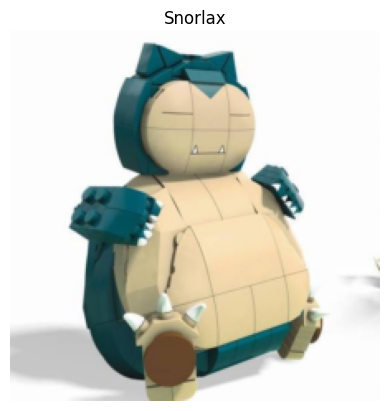

In [29]:
# Let's visualize a image in order to know if data is loaded properly or not

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [31]:
from swin_functions_and_classes import *


model = SwinTransformer(num_classes=len(class_names))

c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Execução do Treinamento

In [ ]:
from going_modular.going_modular import engine
from helper_functions import set_seeds

device = "cuda" if torch.cuda.is_available() else "cpu"
device

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
optimizer = torch.optim.Adam(params=model.parameters(), 
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

## Gráficos de Análise

In [ ]:
# To check out our ViT model's loss curves, we can use the plot_loss_curves function from helper_functions.py
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)